# NYC Taxi ride duration prediction

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

## Import data

In [57]:
data_file = "./data/green_tripdata_2021-01.parquet"
df = pd.read_parquet(data_file)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

## Missing values

In [58]:
miss_values = df.isna().sum()
miss_values = miss_values[miss_values > 0]
miss_columns = miss_values.index

In [59]:

dict_miss_values = {column : df[column][df[column].isna()].index for column in miss_columns}

<h2>Comment </h2>  
The columns have exactly the same number of missing values, so it makes sense to see if the indexes are also the same. If so we can make an hypothesis on why the values are missing and find a reasonable value for replacement

column store_and_fwd_flag: 36047 null elements
column RatecodeID: 36047 null elements
column passenger_count: 36047 null elements
column ehail_fee: 76518 null elements
column payment_type: 36047 null elements
column trip_type: 36047 null elements
column congestion_surcharge: 36047 null elements


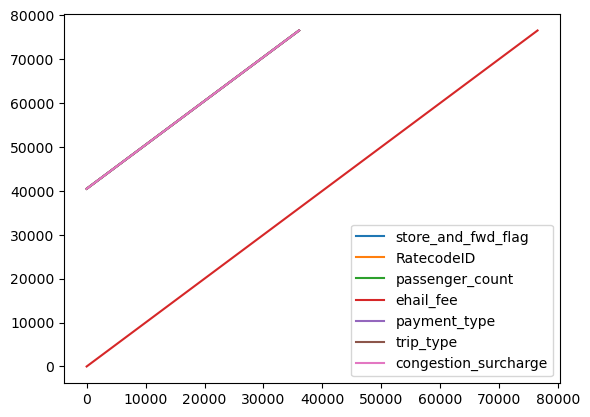

In [60]:
for (column, indexes) in dict_miss_values.items():
    y = indexes.to_list()
    print(f"column {column}: {len(y)} null elements" )
    plt.plot(range(len(y)), y, label = column)
    plt.legend()
    # plt.show()
    

This graph shows that the columns `store_and_fwd_flag`, `RatecodeID`, `passenger_count`, `ehail_fee`, `payment_type` and `trip_type` have missing values at the same indexes. However there is no evident pattern


In [61]:
idxs = dict_miss_values["RatecodeID"]
df.loc[idxs]

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
40471,2,2021-01-01 00:29:00,2021-01-01 00:34:00,None,NaN,193,193,NaN,1.38,11.95,0.00,0.0,2.75,0.00,None,0.3,15.00,NaN,NaN,NaN
40472,2,2021-01-01 00:52:00,2021-01-01 01:09:00,None,NaN,35,181,NaN,3.65,19.15,0.00,0.0,2.75,0.00,None,0.3,22.20,NaN,NaN,NaN
40473,2,2021-01-01 00:18:00,2021-01-01 00:38:00,None,NaN,174,69,NaN,4.34,23.21,0.00,0.0,2.75,0.00,None,0.3,26.26,NaN,NaN,NaN
40474,2,2021-01-01 00:29:00,2021-01-01 00:47:00,None,NaN,61,256,NaN,4.09,20.93,0.00,0.0,2.75,0.00,None,0.3,23.98,NaN,NaN,NaN
40475,2,2021-01-01 00:54:00,2021-01-01 01:17:00,None,NaN,76,108,NaN,10.47,32.96,0.00,0.0,2.75,0.00,None,0.3,36.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [62]:
df.loc[idxs].nunique()

VendorID                     2
lpep_pickup_datetime     19194
lpep_dropoff_datetime    19199
store_and_fwd_flag           0
RatecodeID                   0
PULocationID               246
DOLocationID               252
passenger_count              0
trip_distance             2628
fare_amount               3132
extra                       10
mta_tax                      2
tip_amount                 715
tolls_amount                27
ehail_fee                    0
improvement_surcharge        1
total_amount              2599
payment_type                 0
trip_type                    0
congestion_surcharge         0
dtype: int64

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

## Feature selection

In [64]:
# df.lpep_pickup_datetime - df.lpep_dropoff_datetime

In [65]:
date_vars = ['lpep_pickup_datetime', 'lpep_dropoff_datetime']
categorical_vars = ['PULocationID', 'DOLocationID']
numeric_vars = ['trip_distance']
selected_features = [*date_vars, *categorical_vars, *numeric_vars ]

data = df[selected_features]
data.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance
0,2021-01-01 00:15:56,2021-01-01 00:19:52,43,151,1.01
1,2021-01-01 00:25:59,2021-01-01 00:34:44,166,239,2.53
2,2021-01-01 00:45:57,2021-01-01 00:51:55,41,42,1.12
3,2020-12-31 23:57:51,2021-01-01 00:04:56,168,75,1.99
4,2021-01-01 00:16:36,2021-01-01 00:16:40,265,265,0.00


In [66]:
if 'duration' not in data.columns:
    # data.insert(2,'duration' , data.lpep_dropoff_datetime - data.lpep_pickup_datetime)
    data['duration'] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime

data.duration = data.duration.apply(lambda x: x.total_seconds()/60)

/tmp/ipykernel_24402/2732902593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['duration'] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime
/tmp/ipykernel_24402/2732902593.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.duration = data.duration.apply(lambda x: x.total_seconds()/60)


In [67]:
data.head()

,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance,duration
0,2021-01-01 00:15:56,2021-01-01 00:19:52,43,151,1.01,3.933333
1,2021-01-01 00:25:59,2021-01-01 00:34:44,166,239,2.53,8.750000
2,2021-01-01 00:45:57,2021-01-01 00:51:55,41,42,1.12,5.966667
3,2020-12-31 23:57:51,2021-01-01 00:04:56,168,75,1.99,7.083333
4,2021-01-01 00:16:36,2021-01-01 00:16:40,265,265,0.00,0.066667


## Trip duration distribution and outliers

<Axes: >

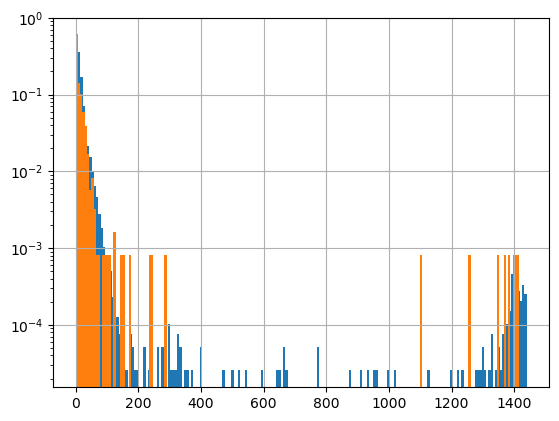

In [68]:
n_bins = 200
idxs1, idxs2 = df[df.trip_type == 1].index, df[df.trip_type == 2].index
data1, data2 = data.loc[idxs1], data.loc[idxs2]
data1.duration.hist(bins=n_bins, log=True, weights=np.ones(len(data1))/len(data1))
data2.duration.hist(bins=n_bins, log=True, weights=np.ones(len(data2))/len(data2))
# data1.duration.hist(bins=n_bins, log=True, weights=np.ones(len(data1))/len(data1))

In [69]:
data.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [70]:
len(data[data.duration < 1])/len(data)
len(data[( data.duration > 1) & (data.duration < 60)])/len(data)

0.9644397396690975

## Final dataset

In [71]:
data = data[(data.duration >= 1) & (data.duration <= 60)]
data[categorical_vars] = data[categorical_vars].astype(str)

In [72]:
data[categorical_vars].dtypes

PULocationID    object
DOLocationID    object
dtype: object

In [73]:
# data[categorical_vars] = data[categorical_vars].astype(str)

In [86]:
dict_train = data[categorical_vars + numeric_vars].to_dict(orient='records')
dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(dict_train)


In [88]:
# dir(X_train)
X_train

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.01],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  2.53],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.12],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  2.5 ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  , 14.48],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.81]])

## Linear regession model

In [89]:
target = 'duration'
y_train = data[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.775258694528294

/tmp/ipykernel_24402/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/simona/anaconda3/envs/sklearn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_24402/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an ax

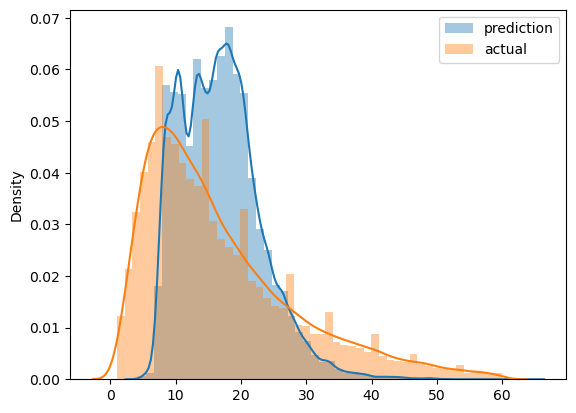

In [90]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()